In [1]:
from OrderBook import Book
from __future__ import annotations

import polars as pl
import seaborn as sns
import tqdm
from databento_dbn import FIXED_PRICE_SCALE, UNDEF_PRICE
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import *
from sklearn.metrics import mean_squared_error, r2_score    
import numpy as np
from features import *

In [2]:
from helpers import prepare_symbol
data = pl.read_parquet("/Users/danny/trading/databento/mbo.parquet")
print(data.shape)
df = prepare_symbol(data, "2024-01-31", "GOOG")
# Get only the second hour of data
# df = df.filter(pl.col("ts_event") < pl.col("ts_event").min() + pl.duration(hours=2))
# df = df.filter(pl.col("ts_event") > pl.col("ts_event").min())
df = df.with_columns(pl.col("ts_event") - pl.col("ts_event").min())
# subtract the minimum timestamp to get the time in seconds
df[:10]

(62131467, 16)


ts_event,action,side,price,size,order_id,symbol
duration[μs],str,str,i64,i16,i64,str
0µs,"""A""","""B""",144380000000,100,43829,"""GOOG"""
20s 207152µs,"""A""","""A""",147900000000,200,4403,"""GOOG"""
3m 29s 585853µs,"""A""","""B""",136890000000,100,43829,"""GOOG"""
3m 29s 585860µs,"""A""","""B""",136890000000,100,43829,"""GOOG"""
3m 29s 585860µs,"""A""","""A""",151380000000,100,43829,"""GOOG"""
4m 30s 109508µs,"""A""","""B""",136890000000,100,43829,"""GOOG"""
4m 30s 109508µs,"""A""","""A""",144450000000,100,43829,"""GOOG"""
4m 30s 113741µs,"""A""","""B""",136890000000,100,43829,"""GOOG"""
4m 30s 113741µs,"""A""","""A""",151380000000,100,43829,"""GOOG"""


In [3]:
book = Book()
best_bids_list = []
best_asks_list = []
num_rows = df.shape[0]
for i, row in enumerate(tqdm.tqdm(df.iter_rows(named=True), total=num_rows)):
    best_bid, best_ask = book.bbo()
    best_bids_list.append({"ts_event": row["ts_event"], "price": best_bid.price, "size": best_bid.size, "total": best_bid.total_size})
    best_asks_list.append({"ts_event": row["ts_event"], "price": best_ask.price, "size": best_ask.size, "total": best_ask.total_size})
    book.apply(row)
    # if the ts_event is > 1 hour, break


100%|██████████| 1747173/1747173 [00:17<00:00, 98520.14it/s] 


In [4]:
def merge_bbo(best_bids_list, best_asks_list, unit="ms"):
    best_bids = pl.DataFrame(best_bids_list)
    best_asks = pl.DataFrame(best_asks_list)
    # Rename to best_bid_price and best_bid_size, best_ask_price and best_ask_size
    best_bids = best_bids.rename({"price": "bid_px_00", "size": "bid_ct_00", "total": "best_bid_total"})
    best_asks = best_asks.rename({"price": "ask_px_00", "size": "ask_ct_00", "total": "best_ask_total"})
    # divide by the fixed price scale
    best_bids = best_bids.with_columns([pl.col("bid_px_00") / FIXED_PRICE_SCALE])
    best_asks = best_asks.with_columns([pl.col("ask_px_00") / FIXED_PRICE_SCALE])
    # Forward fill the missing values

    if unit == "ms": 
        best_bids = best_bids.with_columns(pl.col("ts_event").dt.total_milliseconds())
        best_asks = best_asks.with_columns(pl.col("ts_event").dt.total_milliseconds())
        best_bids = best_bids.group_by("ts_event").agg(
            pl.col("bid_px_00").mean(), pl.col("bid_ct_00").sum(), pl.col("best_bid_total").last()
        )
        best_asks = best_asks.group_by("ts_event").agg(
            pl.col("ask_px_00").mean(), pl.col("ask_ct_00").sum(), pl.col("best_ask_total").last()
        )
        print(best_bids.shape, best_asks.shape)
    elif unit == "s":
        print(best_bids.shape, best_asks.shape)
        best_bids = best_bids.with_columns(pl.col("ts_event").dt.total_seconds())
        best_asks = best_asks.with_columns(pl.col("ts_event").dt.total_seconds())
        print(best_bids.shape, best_asks.shape)
        best_bids = best_bids.group_by("ts_event").agg(
            pl.col("bid_px_00").mean(), pl.col("bid_ct_00").sum(), pl.col("best_bid_total").last()
        )
        best_asks = best_asks.group_by("ts_event").agg(
            pl.col("ask_px_00").mean(), pl.col("ask_ct_00").sum(), pl.col("best_ask_total").last()
        )

    
    # lay out the timestamps
    merged = best_bids.join(best_asks, on="ts_event", how="inner")
    # P

    print(merged.shape, best_bids.shape, best_asks.shape)
    merged = merged.select(pl.all().forward_fill())
    return merged   

def prep_for_prediction(df: pl.DataFrame, offset=1000, lookback="1s"):
    df = df.with_columns(
        spread=bid_ask_spread(df),
        mid_price=mid_price(df),
        weighted_mid_price=weighted_mid_price(df),
        volume_imbalance=volume_imbalance(df)
    )
    feature_cols = [
        'volume_imbalance',
        'weighted_mid_price',
        'spread'
        # 'volatility',
    ]
    # df = df.with_columns(
    #     # log_return=log_return(df),
    #     rolling_weighted_mid_price=rolling_weighted_mid_price(df, lookback),
    #     rolling_volatility=rolling_volatility(df, lookback),
    #     rolling_volume_imbalance=rolling_volume_imbalance(df, lookback),
    # )
    # convert from ms to datetime
    df = df.with_columns(pl.from_epoch("ts_event", time_unit="ms"))
    df = df.set_sorted("ts_event")
    for col in feature_cols:
        df=df.with_columns(pl.col(col).cast(pl.Float32))
    print(df.head)

    for col in tqdm.tqdm(feature_cols, total=len(feature_cols)):
        df = df.with_columns(pl.col(col).rolling_mean(window_size=lookback, by="ts_event").alias(f"rolling_{col}"))
        # df = df.with_columns(pl.col(col).rolling_min(window_size=lookback, by="ts_event").alias(f"rolling_{col}_min"))
        # df = df.with_columns(pl.col(col).rolling_max(window_size=lookback, by="ts_event").alias(f"rolling_{col}_max"))
        # df = df.with_columns(pl.col(col).rolling_std(window_size=lookback, by="ts_event").alias(f"rolling_{col}_std"))
        # df = df.with_columns(pl.col(col).rolling_sum(window_size=lookback, by="ts_event").alias(f"rolling_{col}_sum"))
        # df = df.with_columns(pl.col(col).rolling_median(window_size=lookback, by="ts_event").alias(f"rolling_{col}_median"))
        # df = df.with_columns(pl.col(col).rolling_skew(window_size=lookback, by="ts_event").alias(f"rolling_{col}_skew"))


    df = df.drop("ts_event")
    df = df.with_columns(pl.col("mid_price").diff().shift(-offset).alias("target"))[: -offset]

    # cast to f32
  
    return df

merged = merge_bbo(best_bids_list, best_asks_list, unit="ms")
merged = prep_for_prediction(merged, offset=500)

(582405, 4) (582405, 4)
(582405, 7) (582405, 4) (582405, 4)
<bound method DataFrame.head of shape: (582_405, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ ts_event  ┆ bid_px_00 ┆ bid_ct_00 ┆ best_bid_ ┆ … ┆ spread   ┆ mid_price ┆ weighted_ ┆ volume_im │
│ ---       ┆ ---       ┆ ---       ┆ total     ┆   ┆ ---      ┆ ---       ┆ mid_price ┆ balance   │
│ datetime[ ┆ f64       ┆ i64       ┆ ---       ┆   ┆ f32      ┆ f64       ┆ ---       ┆ ---       │
│ ms]       ┆           ┆           ┆ i64       ┆   ┆          ┆           ┆ f32       ┆ f32       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 1970-01-0 ┆ 144.12    ┆ 107       ┆ 1700      ┆ … ┆ 0.14     ┆ 144.19    ┆ 144.14119 ┆ -493.0    │
│ 1 00:54:2 ┆           ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ 8.757     ┆           ┆           ┆           ┆   ┆          ┆           ┆   

100%|██████████| 3/3 [00:00<00:00, 74.20it/s]


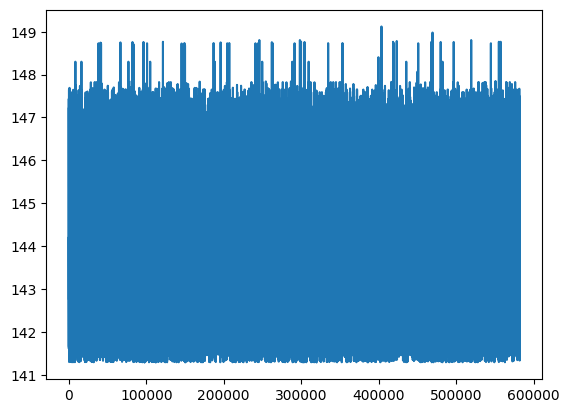

In [12]:
import matplotlib.pyplot as plt
plt.plot(merged["mid_price"])


In [5]:
def preprocess(df):
    # Forward fill the missing values

    df = df.select(pl.all().forward_fill())


    # Split into train and test
    X = df.drop(["target"])
    y = df["target"]
    split = int(0.8 * X.shape[0])

    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    # Convert to numpy arrays
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # Fill any nan values with the mean
    X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
    X_test = np.nan_to_num(X_test, nan=np.nanmean(X_train))
    # Normalize the data
    means = X_train.mean(axis=0)
    stds = X_train.std(axis=0)
    X_train = (X_train - means) / stds
    X_test = (X_test - means) / stds
    target_mean = y_train.mean()
    target_std = y_train.std()
    y_train = (y_train - target_mean) / target_std
    y_test = (y_test - target_mean) / target_std
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess(merged)

In [10]:





def score(model_list, X_test, y_test, round_to=4):
    preds = [model.predict(X_test) for model in model_list]
    mean_preds = np.mean(preds, axis=0)
    metrics = []
    for pred in preds:
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred) * 100
        metrics.append((mse, r2))
    mean_mse = mean_squared_error(y_test, mean_preds)
    mean_r2 = r2_score(y_test, mean_preds) * 100

    for i, (mse, r2) in enumerate(metrics):
        mse = np.round(mse.astype(np.float64), round_to)
        r2 = np.round(r2.astype(np.float64), round_to)
        print(f"Model {i}: mse: {mse}, r2: {r2}")


    mean_mse, mean_r2 = round(mean_mse, round_to), round(mean_r2, round_to)
    print(f"Mean mse: {mean_mse}, mean r2: {mean_r2}")

def train_and_score(X_train, X_test, y_train, y_test, round_to=4):
    model = Lasso(alpha=0.001)
    model2 = XGBRegressor(
        tree_method="hist",
        n_estimators=100,
        learning_rate=0.001,
        max_depth=2,
        subsample=0.05,
        colsample_bytree=0.5,
        reg_alpha=1,
        reg_lambda=1,
    )
    model3 = ElasticNet(alpha=0.00015, l1_ratio=0.5)
    model.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    model3.fit(X_train, y_train)
    # model2 = model
    score([model, model2, model3], X_test, y_test, round_to=round_to)

train_and_score(X_train, X_test, y_train, y_test, round_to=4)

Model 0: mse: 1.0063, r2: 0.0005
Model 1: mse: 1.0063, r2: 0.0001
Model 2: mse: 1.0063, r2: -0.0001
Mean mse: 1.0063, mean r2: 0.0003
